# Small model for CIFAR10

Main ideas:
- architecture similar to pre-activation ResNet, [arXiv:1603.05027 [cs.CV]](https://arxiv.org/abs/1603.05027)
- swish (SiLU) activation function
- factorization of convolution into depthwise and pointwise parts as in MobileNet, [arXiv:1704.04861 [cs.CV]](https://arxiv.org/abs/1704.04861)
- attention module to improve factorized convolution as in MnasNet, [arXiv:1807.11626 [cs.CV]](https://arxiv.org/abs/1807.11626)
- ECA channel attention insead of Squeeze-and-Excitation, [arXiv:1910.03151 [cs.CV]](https://arxiv.org/abs/1910.03151)

## Configuration

Imports

In [32]:
import math
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [33]:
DATA_DIR='./data'

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 32
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-2
EPOCHS = 100

In [34]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [35]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [36]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [37]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

## Model

Utilities

In [38]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Conv1d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [39]:
class NormAct(nn.Sequential):
    def __init__(self, channels):
        super().__init__(nn.BatchNorm2d(channels),
                         nn.SiLU(inplace=True))

ECA channel attention, [arXiv:1910.03151 [cs.CV]](https://arxiv.org/abs/1910.03151)

In [40]:
class ECA(nn.Module):
    def __init__(self, channels, gamma=2, b=1):
        super().__init__()
        
        t = int(abs((math.log(channels, 2) + b) / gamma))
        k = t if t % 2 else t + 1
        padding = (k - 1) // 2
        
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=padding)
    
    def forward(self, x):
        s = self.pool(x)
        c = s.size(1)
        s = s.view(-1, 1, c)
        s = self.conv(s)
        s = s.view(-1, c, 1, 1)
        s = torch.sigmoid(s)
        
        return x * s

Residual block

In [41]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual = nn.Sequential(
            NormAct(in_channels),
            nn.Conv2d(in_channels, in_channels, 3, padding=1, stride=stride, groups=in_channels),
            NormAct(in_channels),
            ECA(in_channels),
            nn.Conv2d(in_channels, out_channels, 1)
        )
        self.shortcut = self.get_shortcut(in_channels, out_channels, stride)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return self.shortcut(x) + self.gamma * self.residual(x)
    
    @staticmethod
    def get_shortcut(in_channels, out_channels, stride):
        if in_channels != out_channels:
            shortcut = nn.Conv2d(in_channels, out_channels, 1)
            if stride > 1:
                shortcut = nn.Sequential(nn.AvgPool2d(stride), shortcut)
        elif stride > 1:
            shortcut = nn.AvgPool2d(stride)
        else:
            shortcut = nn.Identity()
        return shortcut

Main model

In [42]:
class Stage(nn.Sequential):
    def __init__(self, in_channels, out_channels, num_blocks, stride=1):
        super().__init__(
            Block(in_channels, out_channels, stride),
            *[Block(out_channels, out_channels) for _ in range(num_blocks - 1)]
        )

In [43]:
class Body(nn.Sequential):
    def __init__(self, in_channels, channel_list, num_blocks_list, strides):
        layers = []
        for out_channels, num_blocks, stride in zip(channel_list, num_blocks_list, strides):
            layers.append(Stage(in_channels, out_channels, num_blocks, stride))
            in_channels = out_channels
        
        super().__init__(*layers)

In [44]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes, p_drop=0.):
        super().__init__(
            NormAct(in_channels),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(in_channels, classes)
        )

In [45]:
def Stem(in_channels, out_channels, stride):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)

In [46]:
class Net(nn.Sequential):
    def __init__(self, classes, num_blocks_list, channel_list, strides, in_channels=3, head_p_drop=0.):
        super().__init__(
            Stem(in_channels, channel_list[0], strides[0]),
            Body(channel_list[0], channel_list[1:], num_blocks_list, strides[1:]),
            Head(channel_list[-1], classes, head_p_drop)
        )

In [47]:
model = Net(NUM_CLASSES, 
            num_blocks_list =   [6,   6,   6,   4],
            channel_list = [32, 64, 128, 256, 512],
            strides =       [1,  1,   2,   2,   2],
            head_p_drop=0.3)

In [48]:
model.apply(init_linear);

In [49]:
model.to(DEVICE);

In [50]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 1,637,142


## Training

### Setup trainer

In [51]:
loss = nn.CrossEntropyLoss()

In [52]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [53]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [54]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [55]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [56]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [57]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [58]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [59]:
history = defaultdict(list)

In [60]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

### Start training

In [34]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/100 - train: loss 1.085; val: loss 0.988 accuracy 0.648
2/100 - train: loss 0.792; val: loss 0.804 accuracy 0.720
3/100 - train: loss 0.656; val: loss 0.625 accuracy 0.782
4/100 - train: loss 0.625; val: loss 0.578 accuracy 0.799
5/100 - train: loss 0.558; val: loss 0.531 accuracy 0.818
6/100 - train: loss 0.561; val: loss 0.490 accuracy 0.830
7/100 - train: loss 0.470; val: loss 0.457 accuracy 0.844
8/100 - train: loss 0.476; val: loss 0.467 accuracy 0.839
9/100 - train: loss 0.443; val: loss 0.516 accuracy 0.827
10/100 - train: loss 0.475; val: loss 0.482 accuracy 0.834
11/100 - train: loss 0.430; val: loss 0.469 accuracy 0.842
12/100 - train: loss 0.442; val: loss 0.439 accuracy 0.849
13/100 - train: loss 0.442; val: loss 0.434 accuracy 0.854
14/100 - train: loss 0.442; val: loss 0.472 accuracy 0.835
15/100 - train: loss 0.457; val: loss 0.432 accuracy 0.853
16/100 - train: loss 0.455; val: loss 0.436 accuracy 0.857
17/100 - train: loss 0.464; val: loss 0.442 accuracy 0.851
18/100

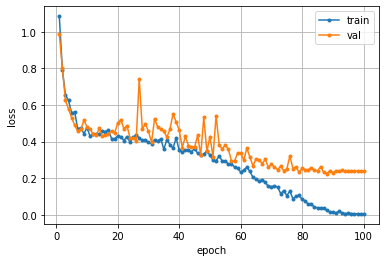

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['train loss']) + 1)
ax.plot(xs, history['train loss'], '.-', label='train')
ax.plot(xs, history['val loss'], '.-', label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
ax.grid()
plt.show()

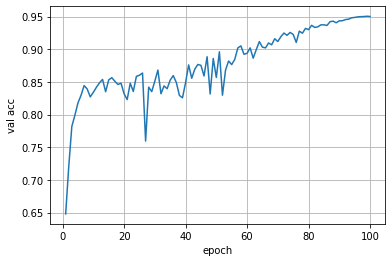

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['val acc']) + 1)
ax.plot(xs, history['val acc'], '-')
ax.set_xlabel('epoch')
ax.set_ylabel('val acc')
ax.grid()
plt.show()